In [1]:
import os
from sktime.datasets import load_from_ucr_tsv_to_dataframe
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np
import glob
import matplotlib.pyplot as plt
from utils import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = 'Car'
X_train, y_train = load_from_ucr_tsv_to_dataframe(
    os.path.join('UCRArchive_2018/', f"{dataset}/{dataset}_TRAIN.tsv")
)

X_test, y_test = load_from_ucr_tsv_to_dataframe(
    os.path.join('UCRArchive_2018/', f"{dataset}/{dataset}_TEST.tsv")
)

In [3]:
X_original = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
X_transformed = X_original.copy()

In [4]:
X_original

dim_0
0    0      1.654107
1      1.621582
2      1.58921...
1    0      1.750569
1      1.710457
2      1.67046...
2    0      1.551691
1      1.517339
2      1.48199...
3    0      1.495626
1      1.457534
2      1.43109...
4    0      1.713808
1      1.675160
2      1.65091...
..                                                 ...
115  0      1.460136
1      1.427414
2      1.39483...
116  0      1.739445
1      1.705766
2      1.67642...
117  0      1.456710
1      1.419963
2      1.38565...
118  0      1.420285
1      1.385552
2      1.35081...
119  0      1.523103
1      1.481917
2      1.45664...

[120 rows x 1 columns]

In [5]:
X_original, X_transformed = interpolate_scale(X_original, X_transformed)

embedding = feature_factory('rocket', 0)
X_original_rep = embedding.fit_transform(X_original)

transformation = transformation_factory("RandomWalk;0.01")
X_transformed = transformation(X_transformed)

X_transformed_rep = embedding.transform(X_transformed)

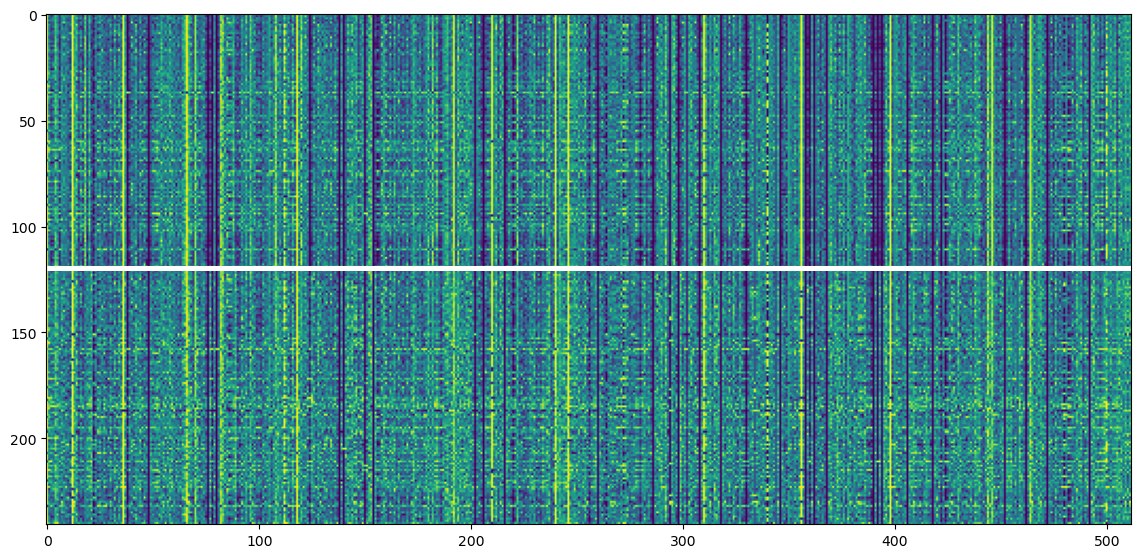

In [6]:
nan_df = pd.DataFrame(np.nan, index=[0], columns=X_transformed_rep.columns)
display_df = pd.concat([X_original_rep, nan_df, X_transformed_rep], axis=0).reset_index(drop=True)

scaler = MinMaxScaler()
dft = pd.DataFrame(scaler.fit_transform(display_df), columns=display_df.columns)

plt.figure(figsize=(14, 10))
plt.imshow(dft)

In [7]:
#X = pd.concat([X_original_rep, X_transformed_rep], axis=0).reset_index(drop=True)
#y = np.array([0]*len(X_original_rep) + [1]*len(X_transformed_rep))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

dffi = {'feature_name': [], 'feature_importance': [], 'run': [], 'transform': []}

for transform in ["RandomWalk;0.01", "Resample;1.3"]:
    for run in range(3):
        embedding = feature_factory('tsfresh', 0)
        X_original_rep = embedding.fit_transform(X_original)

        transformation = transformation_factory(transform)
        X_transformed = transformation(X_transformed)

        X_transformed_rep = embedding.transform(X_transformed)

        X = pd.concat([X_original_rep, X_transformed_rep], axis=0).reset_index(drop=True)
        y = np.array([0]*len(X_original_rep) + [1]*len(X_transformed_rep))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        clf = RandomForestClassifier(n_jobs=-1)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")

        importances = clf.feature_importances_

        for fname, fvalue in zip(X_test.columns, importances):
            dffi['feature_name'].append(fname)
            dffi['feature_importance'].append(fvalue)
            dffi['run'].append(run)    
            dffi['transform'].append(transform)    
        
        
dffi = pd.DataFrame(dffi)

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


In [9]:
def get_group(v):
    return v.split('__')[1]

dffi['feature_group'] = dffi['feature_name'].apply(get_group)
#dffi['feature_group'] = dffi['feature_name'].apply(lambda x: str(x))
dffi

feature_name  feature_importance  \
0        dim_0__variance_larger_than_standard_deviation            0.000000   
1                              dim_0__has_duplicate_max            0.000000   
2                              dim_0__has_duplicate_min            0.000000   
3                                  dim_0__has_duplicate            0.007724   
4                                     dim_0__sum_values            0.000000   
...                                                 ...                 ...   
4657     dim_0__permutation_entropy__dimension_5__tau_1            0.000000   
4658     dim_0__permutation_entropy__dimension_6__tau_1            0.000000   
4659     dim_0__permutation_entropy__dimension_7__tau_1            0.000000   
4660  dim_0__query_similarity_count__query_None__thr...            0.000000   
4661     dim_0__mean_n_absolute_max__number_of_maxima_7            0.000000   

      run        transform                            feature_group  
0       0  RandomWalk;0.01  variance_larger_than_standard_deviation  
1       0  RandomWalk;0.01                        has_duplicate_max  
2       0  RandomWalk;0.01                        has_duplicate_min  
3       0  RandomWalk;0.01                            has_duplicate  
4       0  RandomWalk;0.01                               sum_values  
...   ...              ...                                      ...  
4657    2     Resample;1.3                      permutation_entropy  
4658    2     Resample;1.3                      permutation_entropy  
4659    2     Resample;1.3                      permutation_entropy  
4660    2     Resample;1.3                   query_similarity_count  
4661    2     Resample;1.3                      mean_n_absolute_max  

[4662 rows x 5 columns]

In [10]:
d = dffi[['feature_importance', 'feature_group', 'transform']].groupby(['feature_group', 'transform']).mean().reset_index().sort_values('feature_group')

In [11]:
d

feature_group        transform  \
0                                 abs_energy  RandomWalk;0.01   
1                                 abs_energy     Resample;1.3   
2                           absolute_maximum  RandomWalk;0.01   
3                           absolute_maximum     Resample;1.3   
4                    absolute_sum_of_changes  RandomWalk;0.01   
..                                       ...              ...   
139                                 variance     Resample;1.3   
140  variance_larger_than_standard_deviation  RandomWalk;0.01   
141  variance_larger_than_standard_deviation     Resample;1.3   
142                    variation_coefficient  RandomWalk;0.01   
143                    variation_coefficient     Resample;1.3   

     feature_importance  
0              0.000000  
1              0.003575  
2              0.000000  
3              0.000000  
4              0.007693  
..                  ...  
139            0.000000  
140            0.000000  
141            0.000000  
142            0.000064  
143            0.000000  

[144 rows x 3 columns]

<Axes: xlabel='feature_importance', ylabel='feature_group'>

<Figure size 500x2200 with 0 Axes>

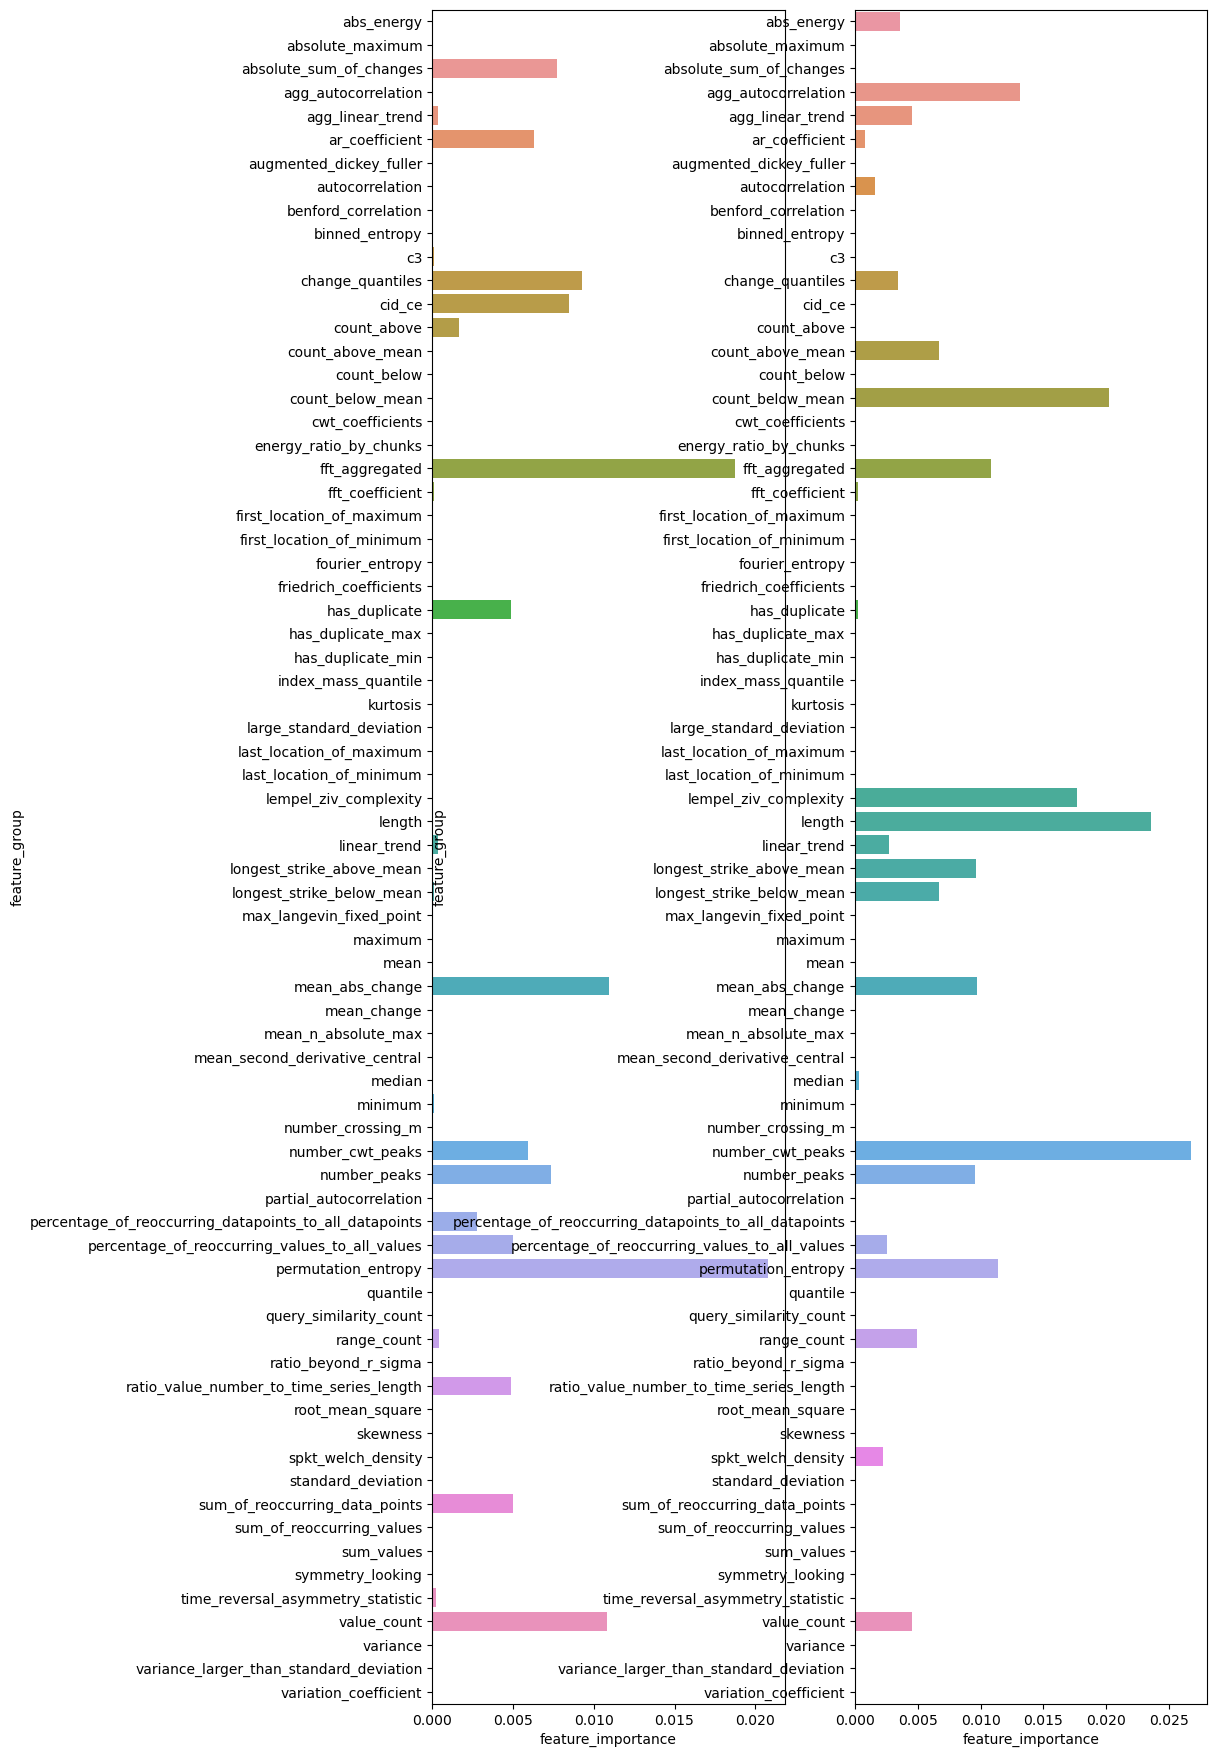

In [12]:
plt.figure(figsize=(5, 22))
fig, ax = plt.subplots(1, 2, figsize=(10, 22))

sns.barplot(data=d.query('transform=="RandomWalk;0.01"').sort_values('feature_group'), y='feature_group', x='feature_importance', ax=ax[0])
sns.barplot(data=d.query('transform=="Resample;1.3"').sort_values('feature_group'), y='feature_group', x='feature_importance', ax=ax[1])

#plt.title("Feature Importances by Group")
#plt.ylabel("Importance")
#plt.xlabel("Feature Group")
#plt.show()